In [ ]:
#TASK - Use any pre trained model on Cifar 10 dataset
!pip install torch torchvision numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


In [ ]:
# Load CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

# Load pre-trained ResNet18 and modify for CIFAR-10
print("\nLoading pre-trained ResNet18...")
model = models.resnet18(pretrained=True)

# Modify the first convolution layer for 32x32 images
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()  # Remove maxpool for smaller images

# Modify the final layer for 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


Training samples: 50000
Test samples: 10000

Loading pre-trained ResNet18...


In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(inputs)}/{len(trainloader.dataset)}] '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.2f}%')

    return train_loss/len(trainloader), 100.*correct/total


In [ ]:
# Testing function
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print(f'\nTest Loss: {test_loss/len(testloader):.3f} | Test Acc: {acc:.2f}%\n')
    return test_loss/len(testloader), acc

In [ ]:
# Training loop
num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("\n" + "="*50)
print("Starting Training")
print("="*50)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 30)

    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)


Starting Training

Epoch 1/20
------------------------------
Epoch: 1 [0/50000] Loss: 2.573 | Acc: 10.16%
Epoch: 1 [12800/50000] Loss: 1.375 | Acc: 51.28%
Epoch: 1 [25600/50000] Loss: 1.062 | Acc: 62.71%
Epoch: 1 [38400/50000] Loss: 0.907 | Acc: 68.31%

Test Loss: 0.481 | Test Acc: 83.68%


Epoch 2/20
------------------------------
Epoch: 2 [0/50000] Loss: 0.382 | Acc: 88.28%
Epoch: 2 [12800/50000] Loss: 0.420 | Acc: 85.19%
Epoch: 2 [25600/50000] Loss: 0.399 | Acc: 86.10%
Epoch: 2 [38400/50000] Loss: 0.380 | Acc: 86.84%

Test Loss: 0.330 | Test Acc: 88.97%


Epoch 3/20
------------------------------
Epoch: 3 [0/50000] Loss: 0.356 | Acc: 84.38%
Epoch: 3 [12800/50000] Loss: 0.270 | Acc: 90.60%
Epoch: 3 [25600/50000] Loss: 0.277 | Acc: 90.52%
Epoch: 3 [38400/50000] Loss: 0.276 | Acc: 90.60%

Test Loss: 0.318 | Test Acc: 89.46%


Epoch 4/20
------------------------------
Epoch: 4 [0/50000] Loss: 0.234 | Acc: 92.19%
Epoch: 4 [12800/50000] Loss: 0.212 | Acc: 92.64%
Epoch: 4 [25600/50000] Lo

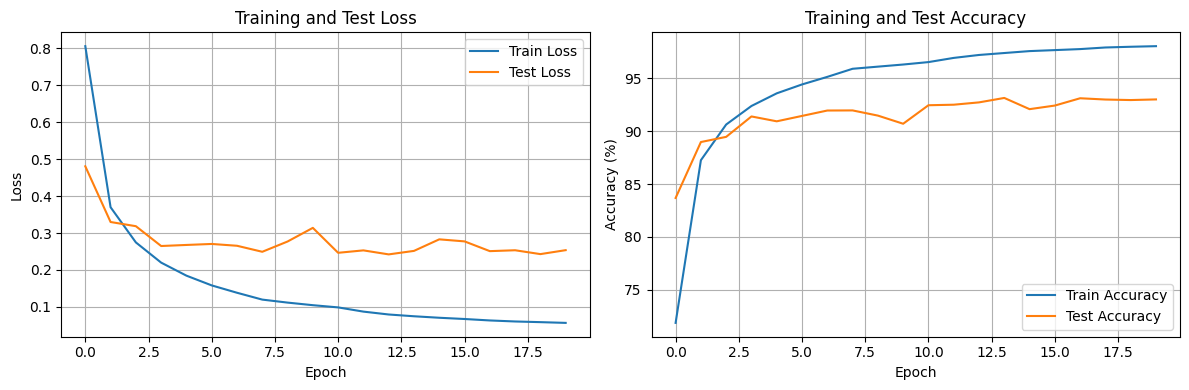

In [ ]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('cifar10_training_results.png', dpi=300, bbox_inches='tight')
plt.show()


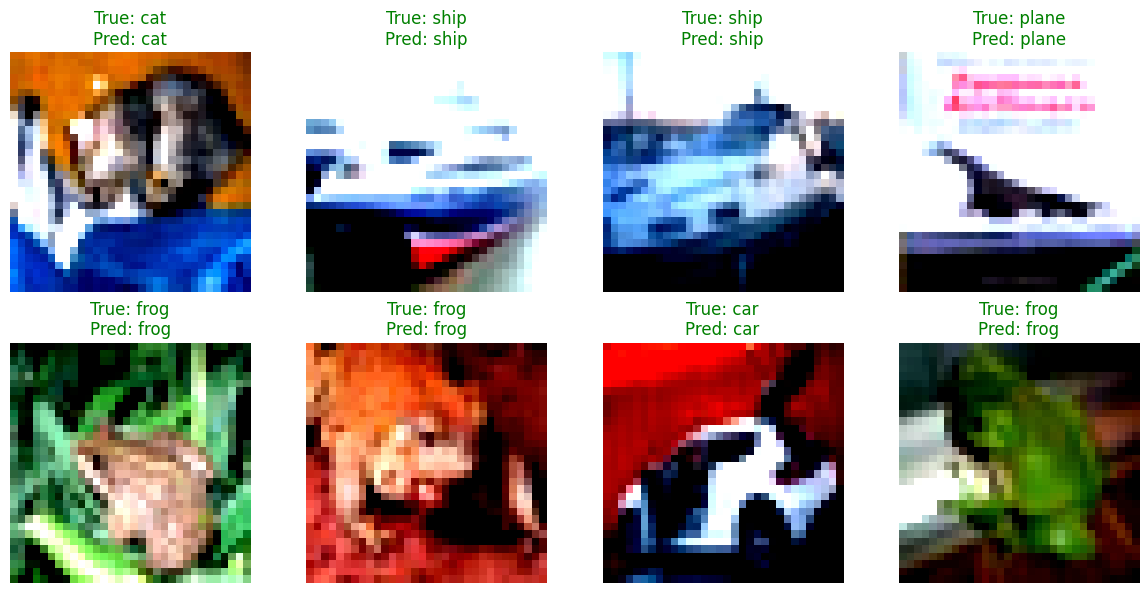

In [ ]:
# Visualize predictions
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

for idx in range(8):
    ax = axes[idx]
    img = images[idx].cpu()
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f'True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}',
                 color='green' if labels[idx] == predicted[idx] else 'red')
    ax.axis('off')

plt.tight_layout()
plt.savefig('cifar10_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'cifar10_resnet18.pth')
print("\nModel saved as 'cifar10_resnet18.pth'")
print(f"\nFinal Test Accuracy: {test_accs[-1]:.2f}%")


Model saved as 'cifar10_resnet18.pth'

Final Test Accuracy: 93.00%
